# HW4 - Graph Neural Networks

## Course Name: Analysis of Medical Images
#### Lecturers: Dr. Rohban
#### Name: Mohammad Hossein Sameti
#### Student ID: 401204932

---

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.




# Introduction

This notebook is designed to introduce you to the basics of Graph Neural Networks (GNNs) using a dataset of pathology images. The steps you will follow are:

- Download the Dataset: Access and download a set of pathology images.
- Data Preprocessing: Prepare the data for processing.
- Nuclei Extraction: Identify the location and dimensions of nuclei in the images.
- GNN Model Implementation: Develop a GNN for classification.
- Experiments: Conduct experiments to test the effectiveness of your model.

You are encouraged to use relevant libraries, but please provide brief explanations for your choices and describe how they work.

## Requirements

In [1]:
!pip install histomicstk --find-links https://girder.github.io/large_image_wheels
!pip install ogb
!pip install gdown
!pip install torchvision
!pip install torch_geometric

Looking in links: https://girder.github.io/large_image_wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.2/643.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 650.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 9.4 MB/s eta 0:00:00
     ━

## Imports

In [1]:
import histomicstk as htk  # HistomicsTK for pathology image analysis
import numpy as np
import scipy as sp
import skimage.io
import skimage.measure
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
import copy

from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split

## Dataset

We will use the BRACS test dataset, a collection of Hematoxylin and Eosin (H&E) stained histopathological images for breast tumor classification. The dataset includes over 4,000 tumor regions-of-interest labeled in 7 categories. You can download it using the following commands. Alternatively, you may use any suitable dataset, but ensure it is accessible during evaluation.

In [ ]:
!gdown 'https://drive.google.com/u/0/uc?id=13TFz_wlUwMKeBGu_YTLXVToJikdGrLEW&export=download' -O data.zip
!unzip data.zip
!rm -rf data.zip

## Preprocessing and Graphic Model Extraction (15 points)

In this section, you will preprocess the images to facilitate model training. Then, identify the position and dimensions of cells using either classic methods or neural networks. Finally, use a neural network (e.g., ResNet18) to embed cell information for node embedding in the GNN.


In [2]:
import os
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles

In [3]:
files=getListOfFiles('/content/data')
imgs = {}
for f in files:
    if f.endswith('.png'):
        temp = f.split('/')
        imgs[temp[-2]] = []

In [4]:
for f in files:
    if f.endswith('.png'):
        temp = f.split('/')
        imgs[temp[-2]].append(f)

In [5]:
def images_preprocess(image):
    # Add your preprocessing steps here
    mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(image)

    normalized_image = htk.preprocessing.color_normalization.reinhard(image, mean_ref, std_ref)
    W = np.array([[0.65, 0.70, 0.29],
                  [0.07, 0.99, 0.11],
                  [0.27, 0.57, 0.78],
                  ]).T

    # perform standard color deconvolution
    im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(normalized_image, W).Stains

    return im_stains[:, :, 0]
def nuclei_extracting(im_nuclei_stain):
    # Implement nuclei extraction here

    foreground_threshold = 60

    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        im_nuclei_stain < foreground_threshold)

    # run adaptive multi-scale LoG filter
    min_radius = 10
    max_radius = 15

    im_log_max, im_sigma_max = htk.filters.shape.cdog(
        im_nuclei_stain, im_fgnd_mask,
        sigma_min=min_radius * np.sqrt(2),
        sigma_max=max_radius * np.sqrt(2),
    )

    # detect and segment nuclei using local maximum clustering
    local_max_search_radius = 10

    im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
        im_log_max, im_fgnd_mask, local_max_search_radius)

    # filter out small objects
    min_nucleus_area = 80

    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

    # compute nuclei properties
    objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

    return objProps, im_nuclei_seg_mask


## Visualization (3 points)

Visualize the results to check accuracy and quality. For example, display a random pathology image alongside the graph of adjacent nuclei.


<ipython-input-5-a1baee39743c>:20: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
<ipython-input-5-a1baee39743c>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask, min_nucleus_area).astype(np.int)


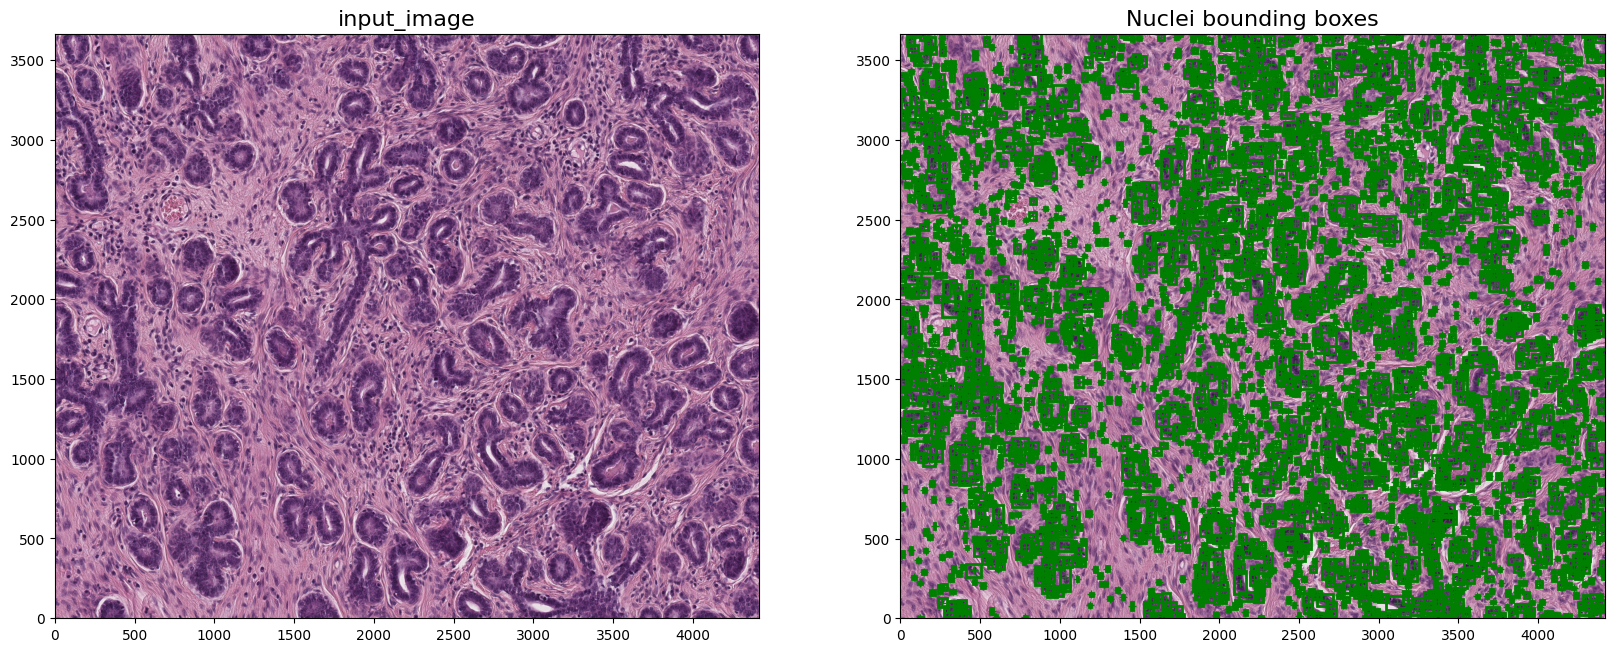

In [6]:
# Visualization code here

input_image = skimage.io.imread('/content/data/1_PB/BRACS_1241_PB_2.png')
preprocessed_image = images_preprocess(input_image)
nucleiextracted_obj, im_nuclei_seg_mask  = nuclei_extracting(preprocessed_image)
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(input_image, origin='lower')
plt.title('input_image', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow( input_image )
plt.xlim([0, input_image.shape[1]])
plt.ylim([0, input_image.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=16)

for i in range(len(nucleiextracted_obj)):

    c = [nucleiextracted_obj[i].centroid[1], nucleiextracted_obj[i].centroid[0], 0]
    width = nucleiextracted_obj[i].bbox[3] - nucleiextracted_obj[i].bbox[1] + 1
    height = nucleiextracted_obj[i].bbox[2] - nucleiextracted_obj[i].bbox[0] + 1

    cur_bbox = {
        'type':        'rectangle',
        'center':      c,
        'width':       width,
        'height':      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)



## Dataset Object

Create a dataset class suitable for your data. You may use geometric_Dataset, Dataset, or any other method. Please explain your implementation logic if you choose an alternative approach.

In [7]:
import torch

from torch.utils.data import Dataset
from torch_geometric.data import Dataset as geometric_Dataset
from torch_geometric.data import Data

label2id = {'0_N' : 0 , '1_PB' : 1, '2_UDH' : 2, '3_ADH' : 3, '4_FEA' : 4, '5_DCIS' : 5,'6_IC' : 6}
resnet_model = resnet18(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])

resnet_model.eval()

class PathologyDataset(Dataset):
    def __init__(self, dic, transform=None):
        super(PathologyDataset, self).__init__()
        self.dic = dic
        self.lens = [len(i) for j, i in dic.items() ]
        self.data = []
        for j, i in dic.items():
          self.data += i
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_image = skimage.io.imread(self.data[idx])
        preprocessed_image = images_preprocess(input_image)
        nucleiextracted_obj, im_nuclei_seg_mask  = nuclei_extracting(preprocessed_image)
        label =  self.data[idx].split('/')[-2]
        if len(nucleiextracted_obj) >= 100:
          nucleiextracted_obj =  np.random.choice(np.array(nucleiextracted_obj), size=100, replace=False)

        ROIs = []
        for nucleus in nucleiextracted_obj:
          ROIs.append(self.transform(input_image[nucleus.bbox[0]:nucleus.bbox[2] + 1, nucleus.bbox[1]:nucleus.bbox[3] + 1]))
        ROIs = torch.stack(ROIs)
        with torch.no_grad():
          ROIs_embeddings = resnet_model(ROIs)


        x = torch.tensor(ROIs_embeddings, dtype=torch.float32)
        edge_index = self.generate_edges(len(ROIs_embeddings))
        y = torch.tensor(label2id[label], dtype=torch.float32)

        data = Data(x=x.squeeze([2,3]), edge_index=edge_index, y=y)

        return data

    def generate_edges(self, num_nodes):
        # Example: Fully connected graph
        row, col = np.meshgrid(np.arange(num_nodes), np.arange(num_nodes))
        row, col = row.reshape(-1), col.reshape(-1)
        edges = torch.tensor([row, col], dtype=torch.long)
        return edges

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))

])
dataset = PathologyDataset(imgs, transform=transform)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## GCN Model Implementation (25 points)

Implement the GCN model as per the provided architecture. Ensure each step is well-documented. [Please follow the figure below to implement your `forward` function.]

![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):
        # TODO: Implement a function that initializes self.convs,
        # self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = nn.ModuleList([GCNConv(input_dim, hidden_dim)])

        # A list of 1D batch normalization layers
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim)])

        # The log softmax layer
        self.softmax = nn.LogSoftmax(dim=1)


        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))

        self.convs.append(GCNConv(hidden_dim, output_dim))
        ############# Your code here ############
        ## Note:
        ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 2. self.convs has num_layers GCNConv layers
        ## 3. self.bns has num_layers - 1 BatchNorm1d layers
        ## 4. You should use torch.nn.LogSoftmax for self.softmax
        ## 5. The parameters you can set for GCNConv include 'in_channels' and
        ## 'out_channels'. For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

        #########################################

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        # TODO: Implement a function that takes the feature tensor x and
        # edge_index tensor adj_t and returns the output tensor as
        # shown in the figure.

        for i in range(len(self.convs) - 1):
            x = F.relu(self.bns[i](self.convs[i](x, adj_t)))
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, adj_t)

        if not self.return_embeds:
            x = self.softmax(x)

        ############# Your code here ############
        ## Note:
        ## 1. Construct the network as shown in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## 4. If return_embeds is True, then skip the last softmax layer

        #########################################

        return x

## Graph Prediction Model (15 points)

Implement a GCN Graph Prediction model using the node embeddings from the GCN model and global pooling to create graph-level embeddings.

### Graph Mini-Batching
Before diving into the actual model, we introduce the concept of mini-batching with graphs. In order to parallelize the processing of a mini-batch of graphs, PyG combines the graphs into a single disconnected graph data object (*torch_geometric.data.Batch*). *torch_geometric.data.Batch* inherits from *torch_geometric.data.Data* (introduced earlier) and contains an additional attribute called `batch`.

The `batch` attribute is a vector mapping each node to the index of its corresponding graph within the mini-batch:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

This attribute is crucial for associating which graph each node belongs to and can be used to e.g. average the node embeddings for each graph individually to compute graph level embeddings.


### Implemention
Now, we have all of the tools to implement a GCN Graph Prediction model!  

We will reuse the existing GCN model to generate `node_embeddings` and then use  `Global Pooling` over the nodes to create graph level embeddings that can be used to predict properties for the each graph. Remeber that the `batch` attribute will be essential for performining Global Pooling over our mini-batch of graphs.


In [36]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(hidden_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = global_mean_pool

        ############# Your code here ############
        ## Note:
        ## 1. Initialize self.pool as a global mean pooling layer
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers

        #########################################

        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        # TODO: Implement a function that takes as input a
        # mini-batch of graphs (torch_geometric.data.Batch) and
        # returns the predicted graph property for each graph.
        #
        # NOTE: Since we are predicting graph level properties,
        # your output will be a tensor with dimension equaling
        # the number of graphs in the mini-batch


        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        #embed = self.node_encoder(x.long())
        node_embeds = self.gnn_node(x, edge_index)
        graph_embeds = self.pool(node_embeds, batch)
        out = self.linear(graph_embeds)
        ############# Your code here ############
        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use the global pooling layer to aggregate features for each individual graph
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict each graph's property

        #########################################

        return out

In [44]:
def train(model, device, data_loader, optimizer, loss_fn):
    # TODO: Implement a function that trains your model by
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0
    total_loss = 0
    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
      batch = batch.to(device)
      if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
          pass

      else:
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y

        ############# Your code here ############
        ## Note:
        ## 1. Zero grad the optimizer
        ## 2. Feed the data into the model
        ## 3. Use `is_labeled` mask to filter output and labels
        ## 4. You may need to change the type of label to torch.float32
        ## 5. Feed the output and label to the loss_fn
        ## (~3 lines of code)
        optimizer.zero_grad()
        output = model(batch)
        output = output[is_labeled]
        labels = batch.y[is_labeled].to(torch.long)
        loss = loss_fn(output, labels)
        total_loss += loss.item()

            # Backward and optimize

        #########################################

        loss.backward()
        optimizer.step()

    return total_loss.item() / len(data_loader)

In [43]:
from tqdm import tqdm

# The evaluation function
def eval(model, device, loader, evaluator, save_model_results=False, save_file=None):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(torch.argmax(pred).detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    if save_model_results:
        print ("Saving Model Predictions")

        # Create a pandas dataframe with a two columns
        # y_pred | y_true
        data = {}
        data['y_pred'] = y_pred.reshape(-1)
        data['y_true'] = y_true.reshape(-1)

        df = pd.DataFrame(data=data)
        # Save to csv
        df.to_csv('our_graph_' + save_file + '.csv', sep=',', index=False)

    return evaluator(input_dict["y_pred"], input_dict["y_true"])

## Traing and Testing

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
args = {'device': device, 'num_layers': 5, 'hidden_dim': 256, 'dropout': 0.5, 'lr': 0.001, 'epochs': 30}

In [40]:
from sklearn.metrics import accuracy_score

evaluator = accuracy_score

# Ex. DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)

from torch.utils.data import DataLoader, random_split
from torch_geometric.data import Data

train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Calculate the sizes of each split
num_data = len(dataset)
num_train = int(train_ratio * num_data)
num_test = int(test_ratio * num_data)
num_val = num_data - num_train - num_test

# Use random_split to create train, test, and validation splits
train_dataset, test_dataset, val_dataset = random_split(dataset, [num_train, num_test, num_val])

# Example DataLoader creation (replace this with your actual DataLoader creation)

from torch_geometric.data import Batch

def custom_collate(data_list):
    return Batch.from_data_list(data_list)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=custom_collate)


In [15]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
model = GCN_Graph(
    512, 7, 5, 0.5).to(device)

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):

    print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)

    print('Evaluating...')
    train_result = eval(model, device, train_loader, evaluator)
    val_result = eval(model, device, val_loader, evaluator)
    test_result = eval(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)

    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {100 * train_acc:.2f}%, Valid: {100 * valid_acc:.2f}% Test: {100 * test_acc:.2f}%')

Training...


Iteration:   2%|▏         | 2/125 [01:00<1:00:07, 29.33s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab060ad0160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Iteration:   3%|▎         | 4/125 [04:03<2:03:00, 61.00s/it]


KeyboardInterrupt: ignored

حداکثر ۱۰۰ هسته استخراج میشود.
بدلیل کمبود وقت آموزش تکیمل نشد!